# Full domain analysis: number of quantiles

Here we will compare the performance of quantile delta mapping adjustments done for the entire 4km ERA5 WRF domain using different values for the `nquantiles` parameter, which prescribes the number of quantiles to use in the adjustment. 

In [6]:
# config cell
from pathlib import Path
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
import baeda
from baeda import tmp_nquantiles_fn


models = ["GFDL-ESM4", "EC-Earth3-Veg", "NorESM2-MM"]

# tmp dir for where results have been precomputed
tmp_dir = Path("/center1/CMIP6/kmredilla/downscaling/eda")

In [2]:
ds = xr.open_zarr(tmp_dir.joinpath("nquantiles_pridx_cvm_allmodels_historical.zarr"))

### Domain-wide boxplots of 2-sample Cramér–von Mises $p$-values for different nquantile values and indicators

In [3]:
df = ds.to_dataframe().reset_index()[
    ["model", "n_quantiles", "dpi_pval", "rx1day_pval"]
]

df = df.melt(
    id_vars=["model", "n_quantiles"],
    value_vars=["rx1day_pval", "dpi_pval"],
    var_name="indicator",
    value_name="pval",
)

df["indicator"] = df["indicator"].str.replace("_pval", "")

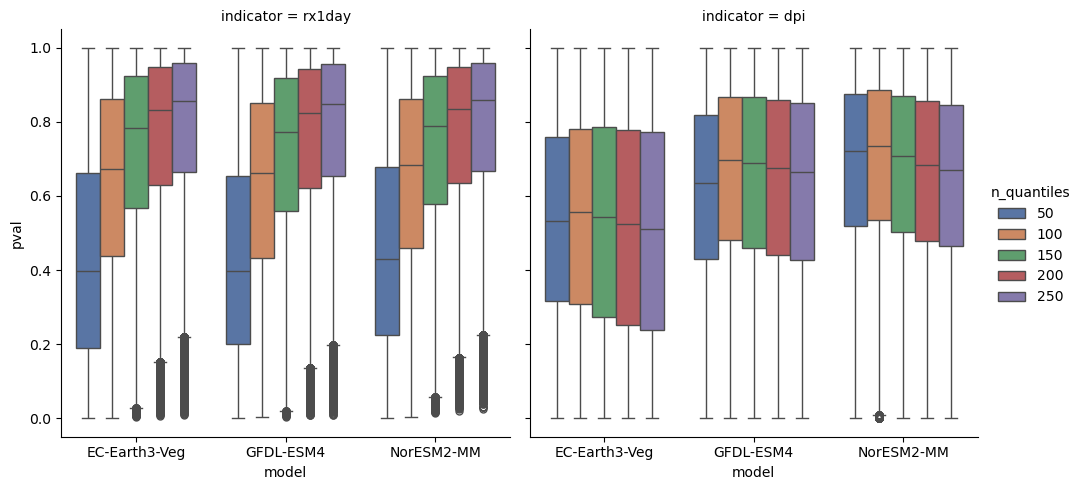

In [ ]:
sns.catplot(
    df,
    x="model",
    col="indicator",
    y="pval",
    hue="n_quantiles",
    kind="box",
    palette="deep",
)

In [ ]:
var_id = "pr"
era5_idx = xr.open_zarr(tmp_dir.joinpath("pridx_era5.zarr"))


def plot_climo_deltas(model):
    das = []
    for nquantiles in [50, 250]:
        hist_idx = xr.open_zarr(
            tmp_dir.joinpath(
                tmp_nquantiles_fn.format(
                    nquantiles=nquantiles,
                    var_id=var_id + "idx",
                    model=model,
                    scenario="historical",
                )
            )
        )
        hist_idx.load()
        hist_idx = hist_idx

        mean_idx_deltas = hist_idx["rx1day"].mean(dim="time").isel(
            n_quantiles=0, experiment=0, drop=True
        ) - era5_idx["rx1day"].mean(dim="time")

        das.append(mean_idx_deltas)

    das[0].attrs["units"] = "mm"
    kwargs = dict(
        da1=das[0],
        da2=das[1],
        title1="50 quantiles",
        title2="250 quantiles",
        plot1_kwargs=dict(add_colorbar=False, cmap="BrBG"),
        plot2_kwargs=dict(x="x", add_colorbar=False, cmap="BrBG"),
        main_title=f"rx1day climatology deltas, {model} $-$ ERA5",
    )

    baeda.plot_sxs(**kwargs)

## Mean Rx1day deltas (GCM - ERA5) for least and most quantiles tested:

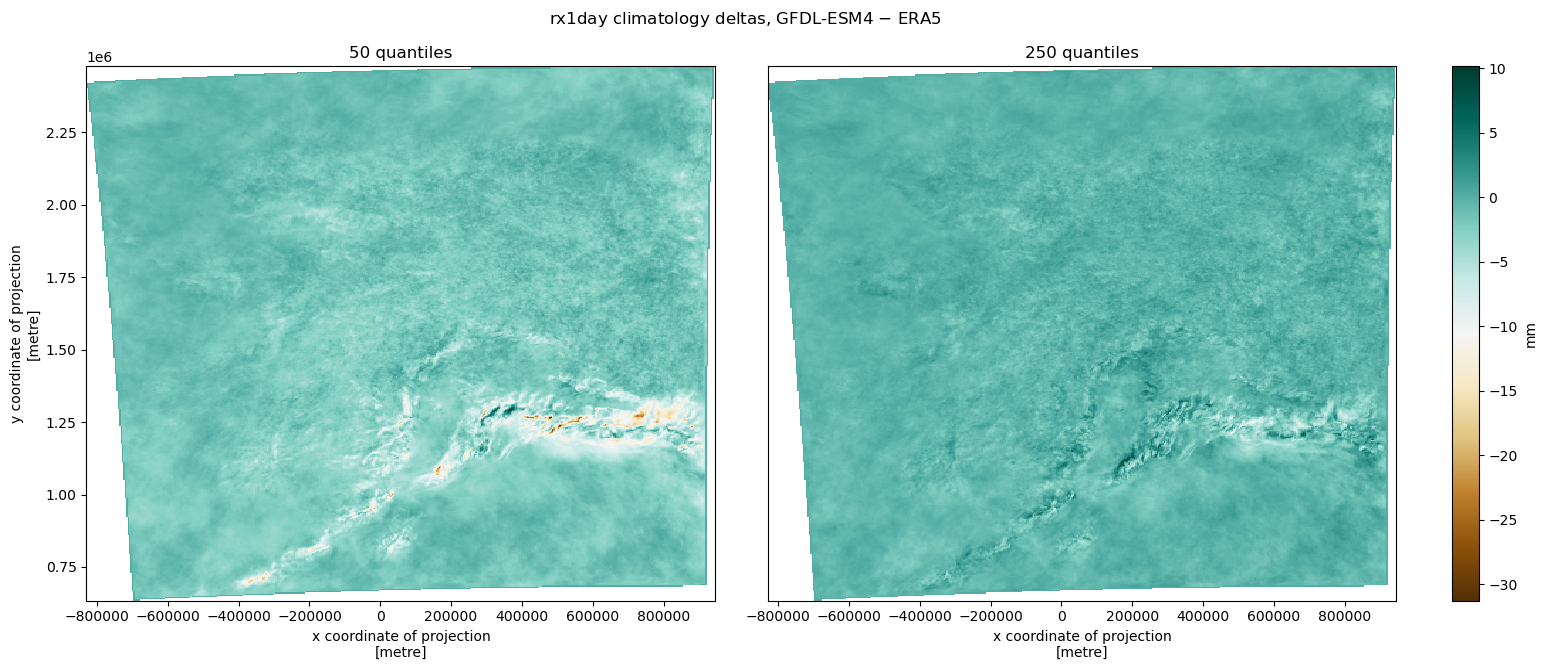

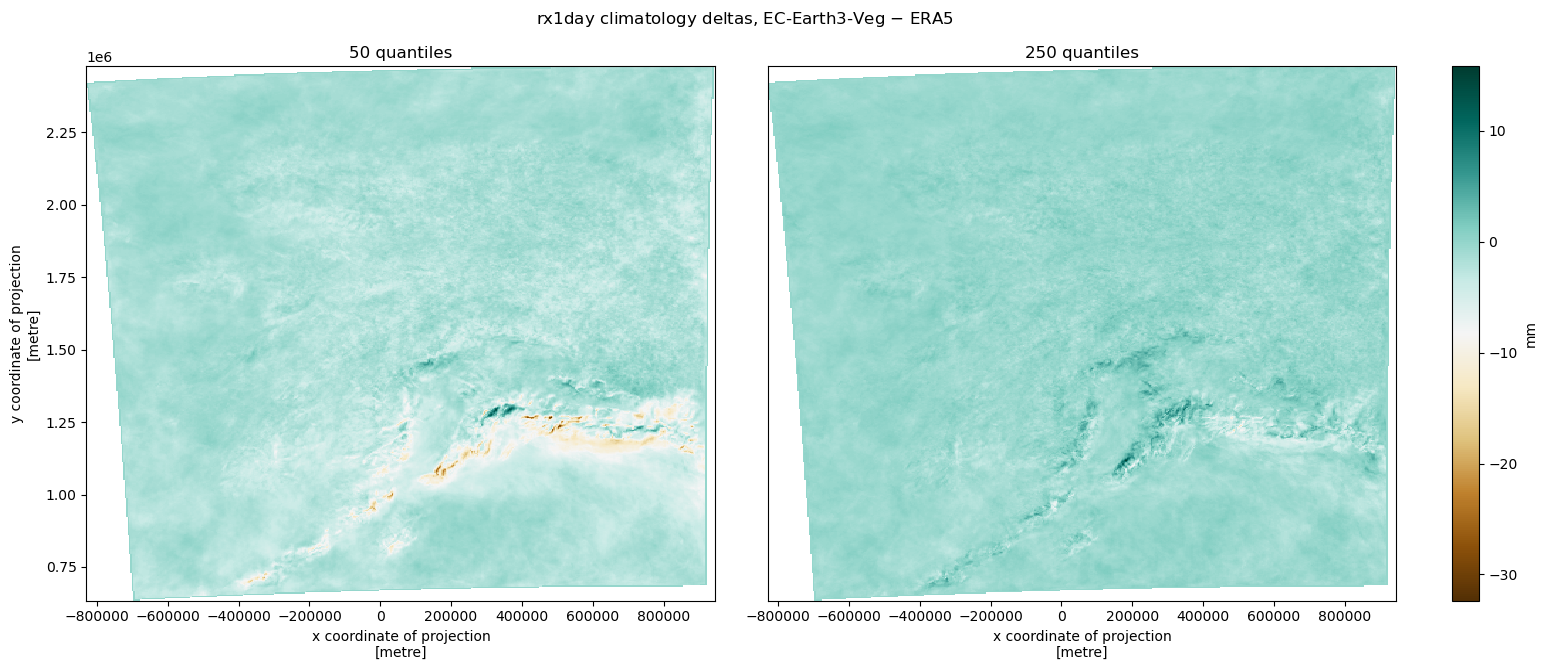

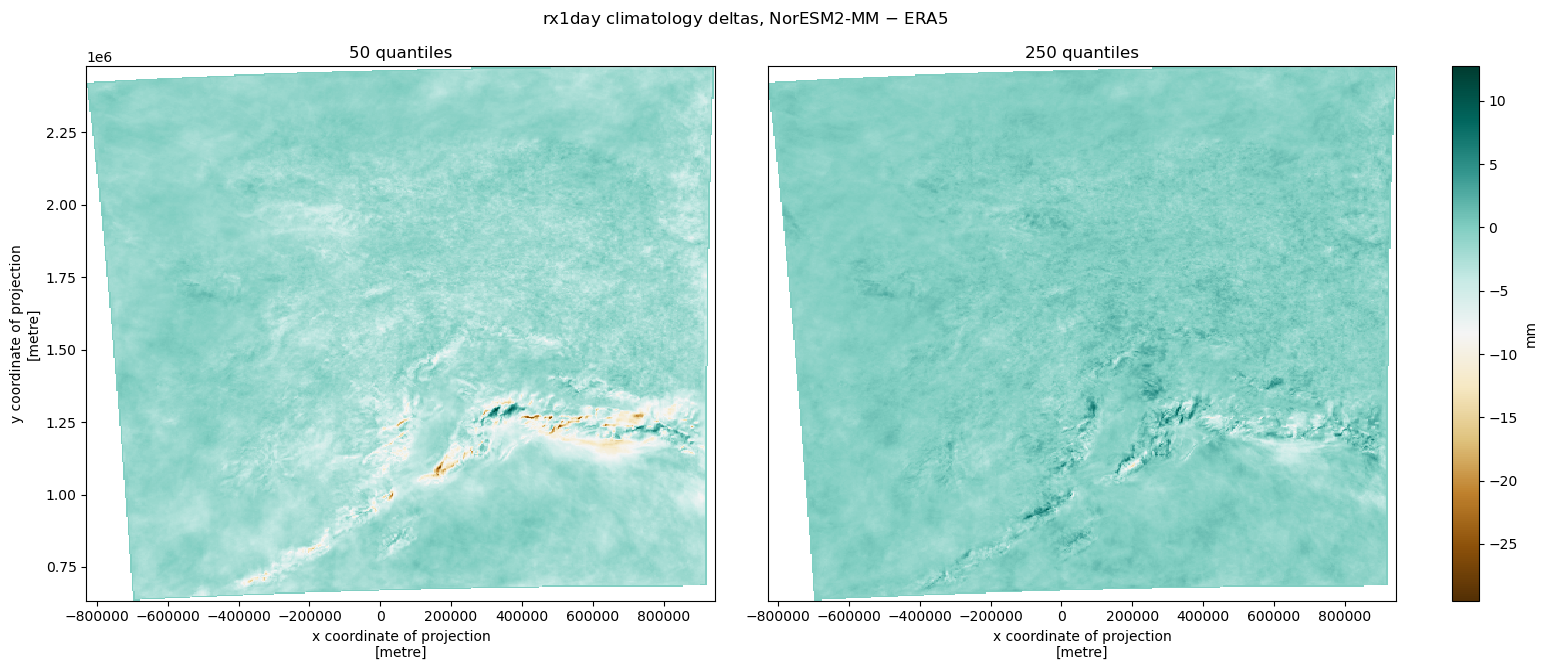

In [13]:
for model in models:
    plot_climo_deltas(model)